# House Prices: Advanced Regression Techniques
Competition Description


Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Practice Skills
Creative feature engineering 
Advanced regression techniques like random forest and gradient boosting
Acknowledgments
The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset.

_Source: [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)_

## Table of Contents <a name='table'></a>
- [Load Data](#Load-Data)
- [Find 'Na' Values](#na)
  - [Explore 'Na' Values](#cleanNa)
  - [Fill 'Na' Values](#fillNa)
- [Explore Target Variable (SalePrice)](#target)
- [Explore Continuous Values](#continuous)

***

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.impute import SimpleImputer

## Load Data <a name='Load-Data'></a>
[Table of Cotents](#table)

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
X_train_data = train_data.copy()
X_test_data = test_data.copy()

In [5]:
print(X_train_data.shape)
print(X_test_data.shape)

(1460, 81)
(1459, 80)


In [6]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
def get_feature_list(X_train_data=X_train_data):
    cont_features = X_train_data.select_dtypes(include=np.number).columns.tolist()
    cat_features = X_train_data.select_dtypes(include='object').columns.to_list()
    return (cont_features, cat_features)

In [8]:
cont_features, cat_features = get_feature_list()

## Find and Analyse 'NA' Values <a name ='findNa'></a>
[Table of Contents](#table)

In [9]:
def find_na(df):
    na_find = df.isna().any()
    na_values = df.loc[:,na_find]
    na_col = na_values.columns.tolist()
    heatmap = sns.heatmap(X_train_data.isna(),cmap='binary', cbar=False, yticklabels='none')
    return heatmap

<AxesSubplot:>

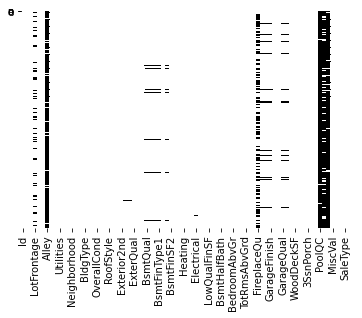

In [10]:
find_na(X_train_data)

<AxesSubplot:>

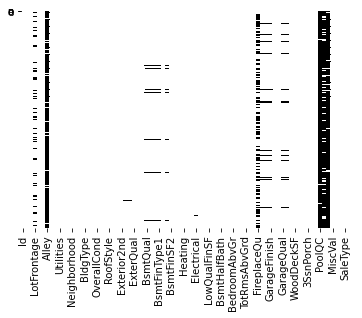

In [11]:
find_na(X_test_data)

In [12]:
na_sum = X_train_data.isna().sum().sort_values(ascending=False)
print(na_sum.loc[na_sum > 0])
print(f'Columns with NaN values: {na_sum.loc[na_sum > 0].count()}')

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64
Columns with NaN values: 19


### Clean 'Na' Values <a name='cleanNa'></a>
[Table of Contents](#table)

Comparing our missing values to our data dictionary many of these 'na' values are a descriptive feature of a dwelling that does not have said feature. 'PoolQC' houses without a pool don't have a 'Pool Quality' rating.

We will fill these 'na' values with 'dna' for does not apply since this is a feature in it of itself.

Column Name| 'Na' Description
-----------|---------------
MiscFeature | None
PoolQC | No Pool
Alley | No alley access
BsmtFinType1 | No Basement
Fence | No Fence
Fireplace | No Fireplace
FireplaceQu | No Fireplace
GarageQual | No Garage
GarageFinish | No Garage
GarageCond | No Garage
GarageType | No Garage    
BsmtExposure | No Basement
BsmtCond | No Basement
BsmtQual | No Basement
BsmtFinType2 | No Basement
BsmtFullBath | None
BsmtHalfBath | None
GarageArea | No Garage

LotFrontage is a measurement.  We will fill this with '0'.
All other NA

In [13]:
dna = ['PoolQC','Alley','BsmtFinType1','Fence','Fireplaces',\
       'FireplaceQu','GarageQual','GarageFinish','GarageCond',\
       'GarageType','BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2',\
       'BsmtFullBath','BsmtHalfBath','GarageArea','MiscFeature']
zero_measure = ['LotFrontage','MasVnrArea','TotalBsmtSF','BsmtFinSF1','BsmtFinSF2']

In [14]:
def impute(df, feature1, feature2):
    
    dna_imputer = SimpleImputer(fill_value='dna',strategy='constant', add_indicator=False)
    dna_out = dna_imputer.fit_transform(df[feature1])
    df.loc[:,feature1] = dna_out
    
    zero_imputer = SimpleImputer(fill_value=0,strategy='constant')
    zero_out = zero_imputer.fit_transform(df[feature2])
    df.loc[:,feature2] = zero_out
    
    print(df.isna().sum().sort_values(ascending=False))

In [15]:
impute(X_train_data, dna, zero_measure)

GarageYrBlt     81
MasVnrType       8
Electrical       1
SalePrice        0
ExterCond        0
                ..
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
Id               0
Length: 81, dtype: int64


Minimal 'Na' values after imputation.  Dropping remaining rows with 'Na' values.

In [16]:
X_train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,dna,Reg,Lvl,AllPub,...,0,dna,dna,dna,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,dna,Reg,Lvl,AllPub,...,0,dna,dna,dna,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,dna,IR1,Lvl,AllPub,...,0,dna,dna,dna,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,dna,IR1,Lvl,AllPub,...,0,dna,dna,dna,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,dna,IR1,Lvl,AllPub,...,0,dna,dna,dna,0,12,2008,WD,Normal,250000


In [17]:
garage_mode = X_train_data['GarageYrBlt'].mode()[0]
X_train_data['GarageYrBlt'].fillna(garage_mode, inplace=True)
X_train_data.dropna(inplace=True)
X_train_data.dropna(inplace=True)

In [18]:
(X_train_data.isna().any or X_test.isna().any) == True

False

---

## Target Variable (SalePrice) <a name='target'></a>
[Table of Contents](#table)

In [19]:
y_train = X_train_data['SalePrice']

Original Skew: 1.8831110462405252
Transformed Skew: 0.1219499636780384


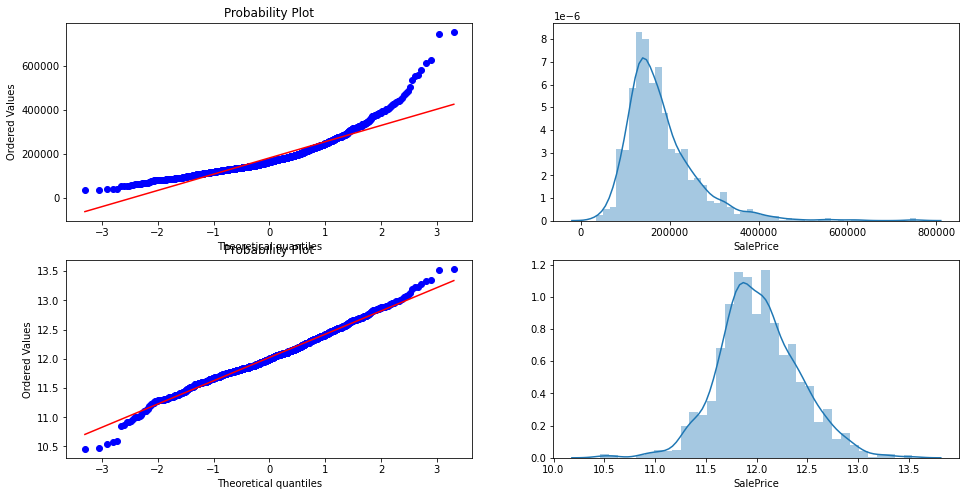

In [20]:
plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
stats.probplot(y_train, dist='norm', fit=True, plot=plt.gca())
plt.subplot(2,2,2)
sns.distplot(y_train)

y_log1p = np.log1p(y_train)
plt.subplot(2,2,3)

stats.probplot(y_log1p, dist='norm', fit=True, plot=plt.gca())
plt.subplot(2,2,4)
sns.distplot(y_log1p)
print(f'Original Skew: {y_train.skew()}')
print(f'Transformed Skew: {y_log1p.skew()}')

---

## Continuous Features <a name='continuous'></a>
[Table of Contents](#table)

In [21]:
corr = X_train_data.corr(method='pearson')

<AxesSubplot:>

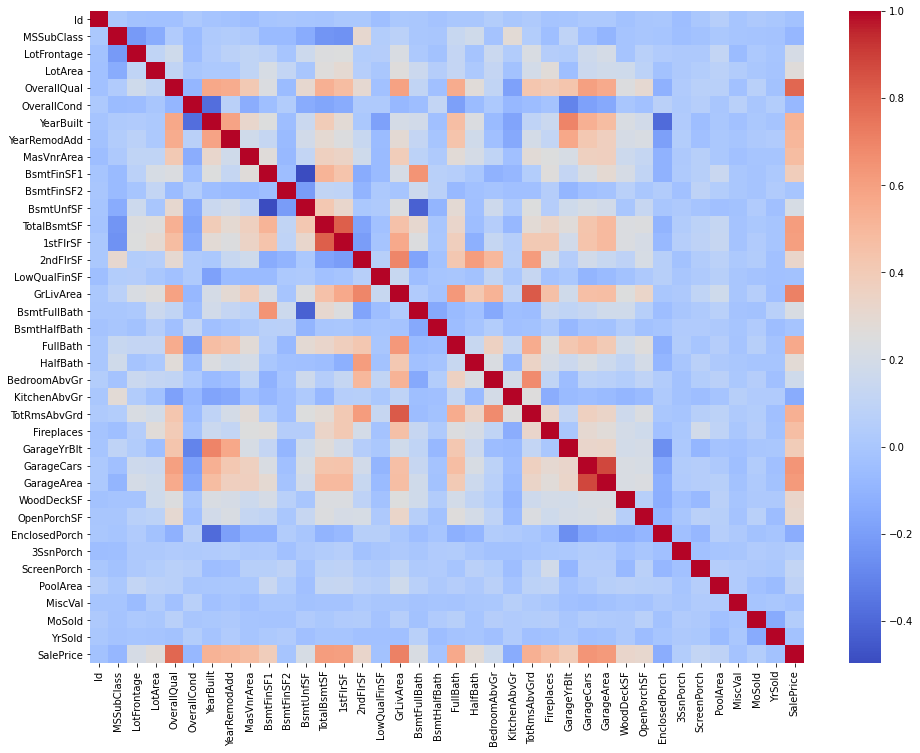

In [22]:
plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap='coolwarm')

In [23]:
corr_values = X_train_data.loc[:,cont_features].corrwith(X_train_data.SalePrice) \
.sort_values(ascending=False)

<AxesSubplot:>

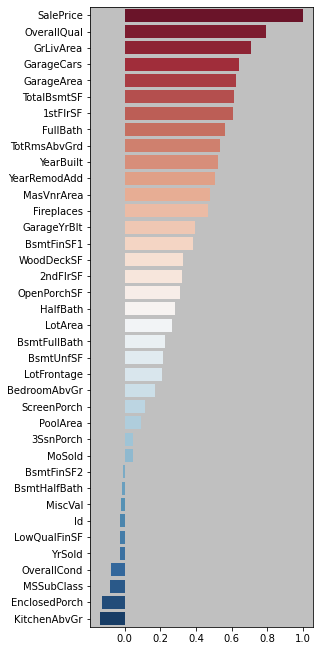

In [24]:
plt.figure(figsize=(4, len(cont_features) * .30))
plt.gca(facecolor='silver')
sns.barplot(x=corr_values,y=corr_values.index, orient='h', palette='RdBu')

In [25]:
ordinal_features = []

def sort(column, sort):
    
    if sort == 'ordinal':
        ordinal_features.append(column)
        print(f'{column} Has been added to the ordinal feature list.')

    elif sort == 'one_hot':
        one_hot_features.append(column)
        print(f'{column} Has been added to the one_hot feature list.')
         
    else:
        return 'Unkown sort value'
    
    return

In [144]:
def outlier_finder(column, k=1.5, df=X_train_data):
    for _ in df[column]:
        q1, q3 = np.percentile(df[column], 25), np.percentile(df[column], 75)
        IQR = q3 - q1
        limit = IQR * k
        lower, upper = q1 - limit, q3 + limit
        outliers = (df[(df[column] > upper)].index)
        out_index = (df[(df[column] > upper)].any(1))
        print(f'{df[column]} : {upper}')
            
    return outliers, out_index

In [74]:
def scribe_stats(column, df=X_train_data):
    
    fig = plt.figure(figsize=(16,4), tight_layout=True)
    
    fig.subplots(1,3)
    
    fig.suptitle(f'Feature Label: {str(column)}', size=20)
    
    plt.subplot(1,3,1)
    sns.distplot(df[column])
    
    plt.subplot(1,3,2)
    sns.boxplot(data=df[column])

    plt.subplot(1,3,3)
    sns.scatterplot(x=df[column],y=df.SalePrice)
    
    plt.show()
    
    outlier_count = outlier_finder(column)[0]
    
    print(f'Skew: {df[column].skew()},\nKurtosis: {df[column].kurtosis()},\n\n\
Outlier Count: {outlier_count}\n\n{df[column].describe()}')
    return

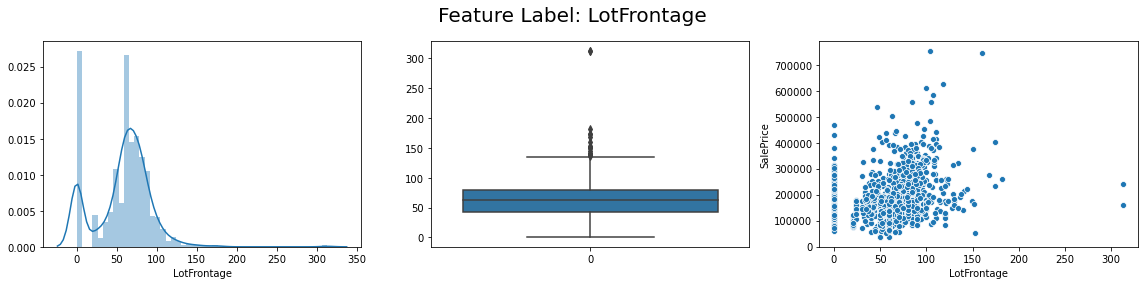

Skew: 0.2730990363240021,
Kurtosis: 3.6437980369059235,

Outlier Count: 16

count    1451.000000
mean       57.624397
std        34.655808
min         0.000000
25%        42.000000
50%        63.000000
75%        79.000000
max       313.000000
Name: LotFrontage, dtype: float64


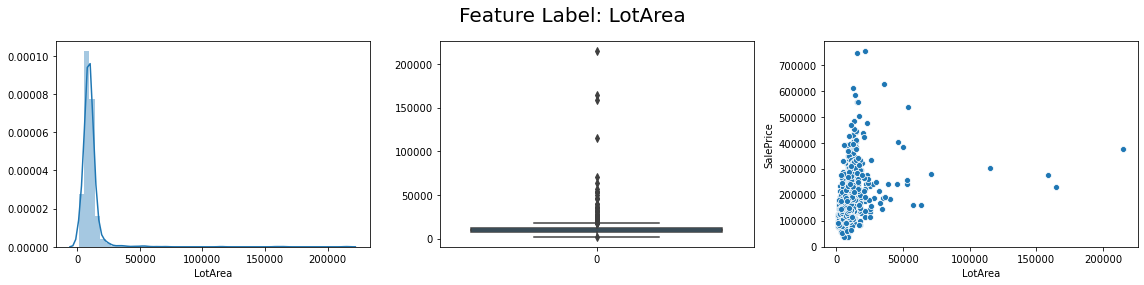

Skew: 12.235741743336332,
Kurtosis: 203.58407874591538,

Outlier Count: 66

count      1451.000000
mean      10507.808408
std        9992.987081
min        1300.000000
25%        7537.500000
50%        9477.000000
75%       11600.000000
max      215245.000000
Name: LotArea, dtype: float64


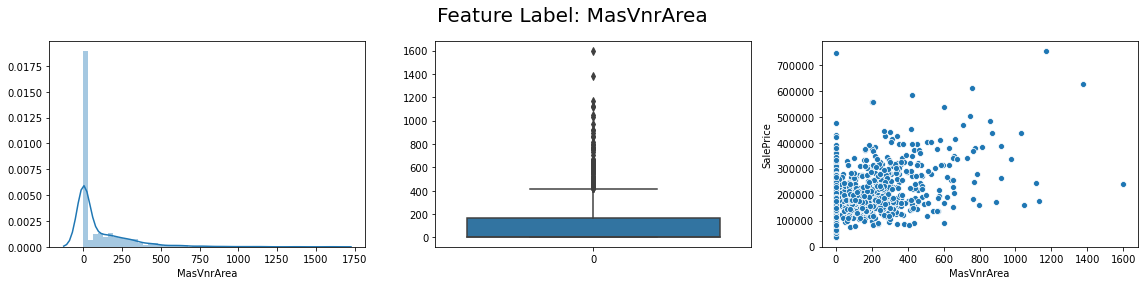

Skew: 2.6680164807560303,
Kurtosis: 10.075050040316713,

Outlier Count: 96

count    1451.00000
mean      103.75672
std       181.10815
min         0.00000
25%         0.00000
50%         0.00000
75%       166.00000
max      1600.00000
Name: MasVnrArea, dtype: float64


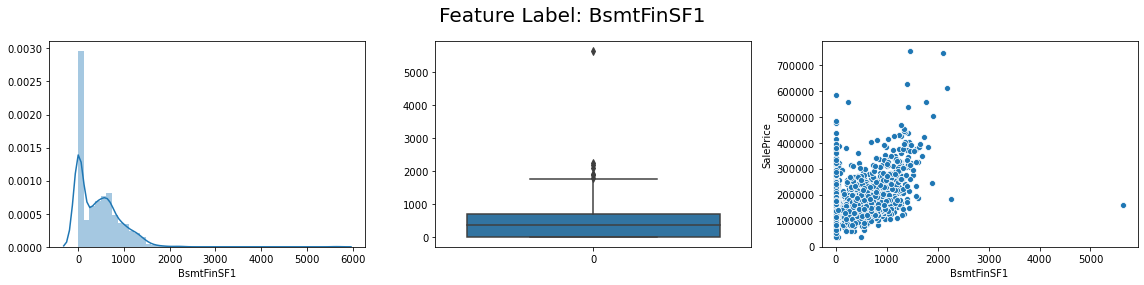

Skew: 1.7025820993769891,
Kurtosis: 11.293695871215649,

Outlier Count: 7

count    1451.000000
mean      442.274983
std       455.369276
min         0.000000
25%         0.000000
50%       381.000000
75%       707.000000
max      5644.000000
Name: BsmtFinSF1, dtype: float64


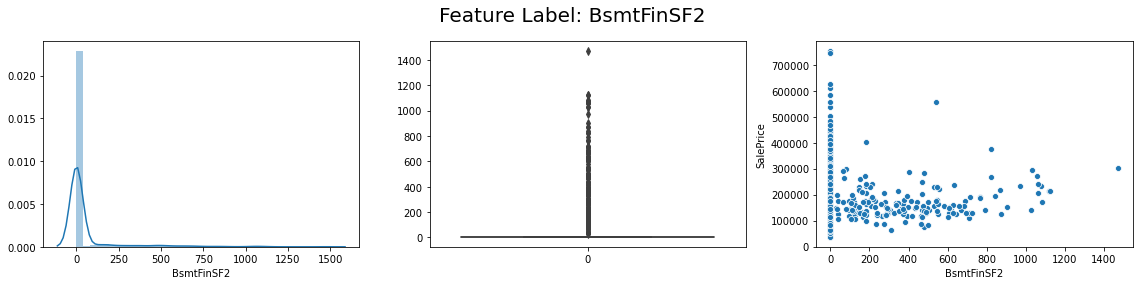

Skew: 4.240229558090081,
Kurtosis: 19.964622505812862,

Outlier Count: 167

count    1451.000000
mean       46.838043
std       161.777324
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1474.000000
Name: BsmtFinSF2, dtype: float64


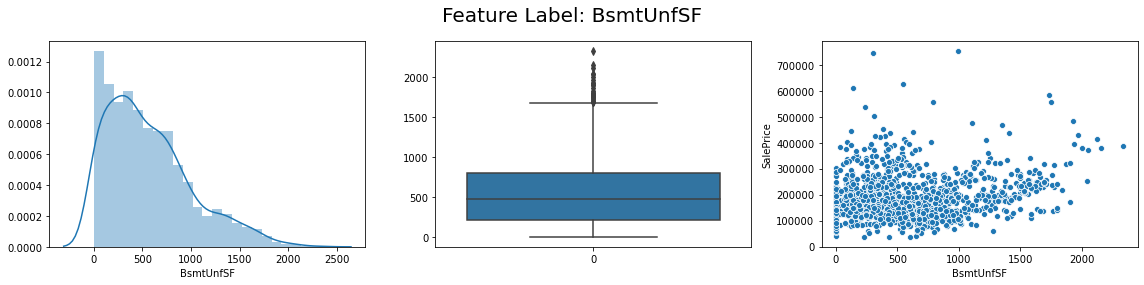

Skew: 0.9199767396130494,
Kurtosis: 0.47511903763031427,

Outlier Count: 28

count    1451.000000
mean      567.197105
std       442.209192
min         0.000000
25%       222.000000
50%       479.000000
75%       808.000000
max      2336.000000
Name: BsmtUnfSF, dtype: float64


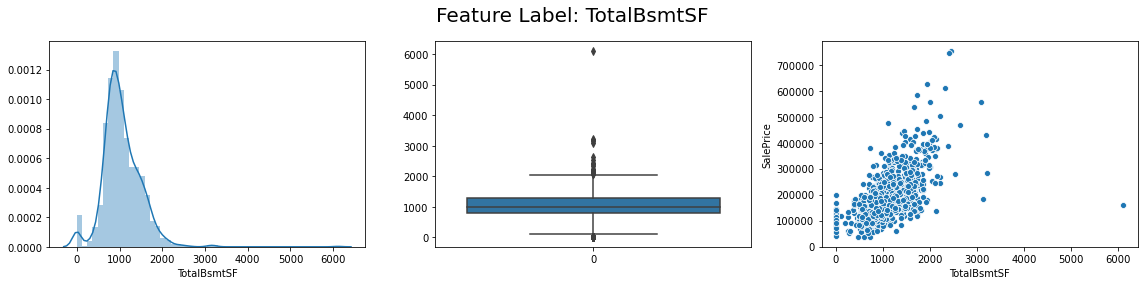

Skew: 1.5355663165360056,
Kurtosis: 13.44412043406942,

Outlier Count: 23

count    1451.000000
mean     1056.310131
std       437.914609
min         0.000000
25%       795.000000
50%       991.000000
75%      1297.500000
max      6110.000000
Name: TotalBsmtSF, dtype: float64


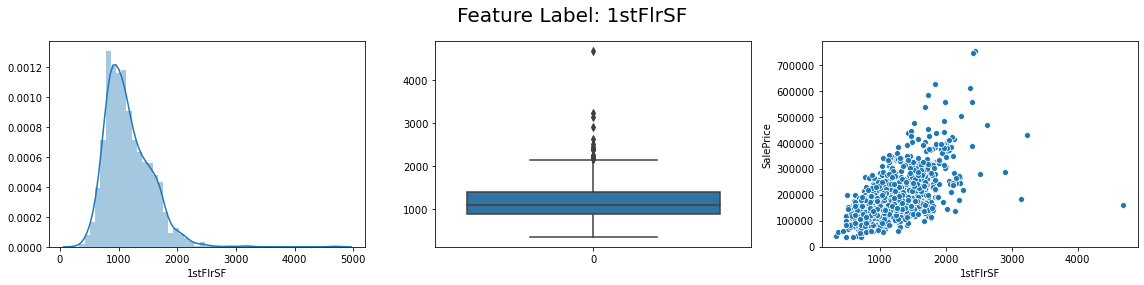

Skew: 1.373141509130297,
Kurtosis: 5.832535396333348,

Outlier Count: 19

count    1451.000000
mean     1161.551344
std       385.002532
min       334.000000
25%       882.000000
50%      1086.000000
75%      1391.000000
max      4692.000000
Name: 1stFlrSF, dtype: float64


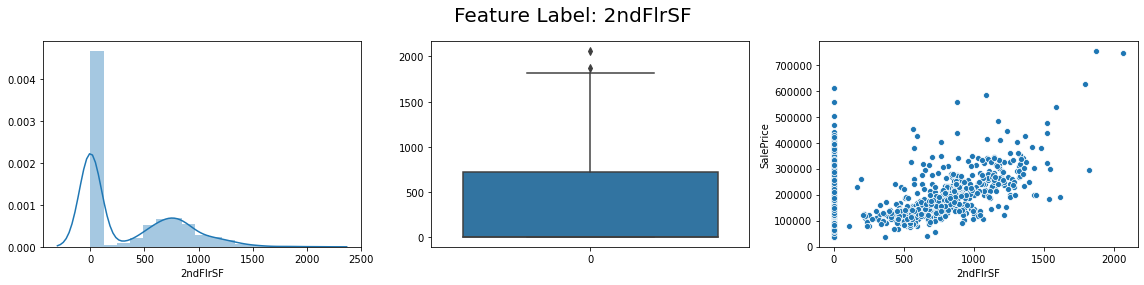

Skew: 0.8157663449459674,
Kurtosis: -0.545279781280025,

Outlier Count: 2

count    1451.000000
mean      346.742247
std       436.453277
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64


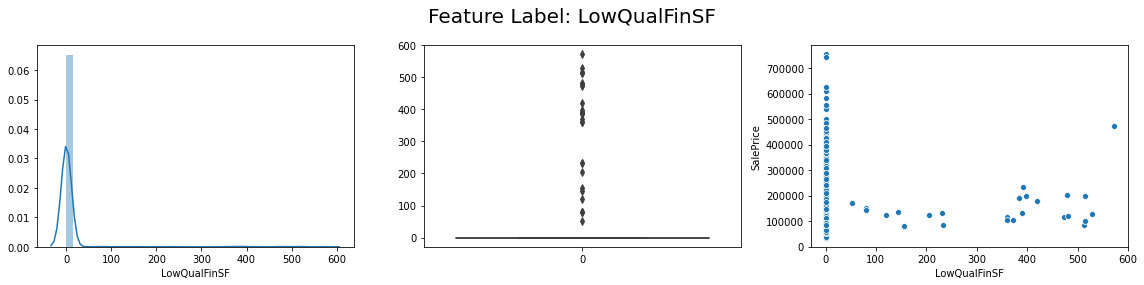

Skew: 8.982567341903248,
Kurtosis: 82.69356902297045,

Outlier Count: 26

count    1451.000000
mean        5.880772
std        48.771560
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       572.000000
Name: LowQualFinSF, dtype: float64


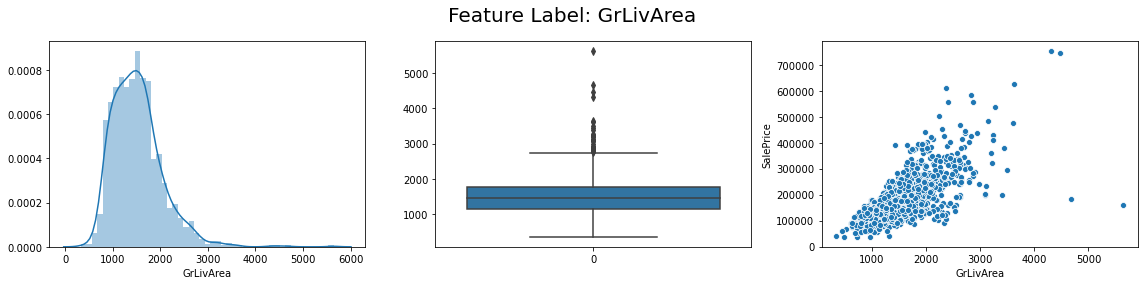

Skew: 1.3735124123402647,
Kurtosis: 4.927435795783476,

Outlier Count: 31

count    1451.000000
mean     1514.174363
std       525.799521
min       334.000000
25%      1128.000000
50%      1464.000000
75%      1776.000000
max      5642.000000
Name: GrLivArea, dtype: float64


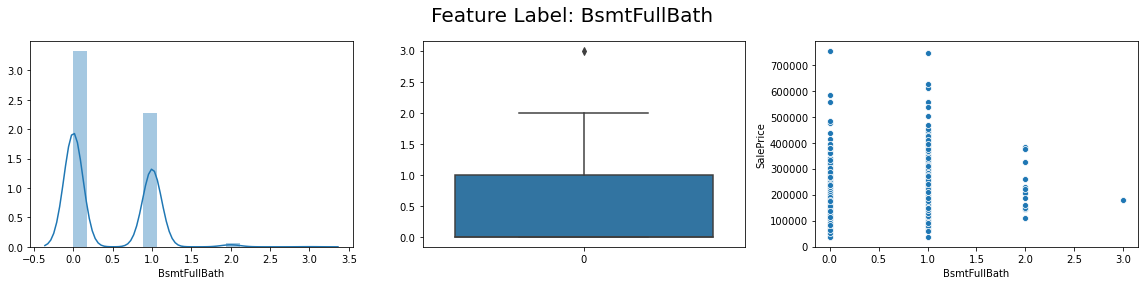

Skew: 0.6041894810109277,
Kurtosis: -0.824718148554695,

Outlier Count: 1

count    1451.000000
mean        0.423846
std         0.518842
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: BsmtFullBath, dtype: float64


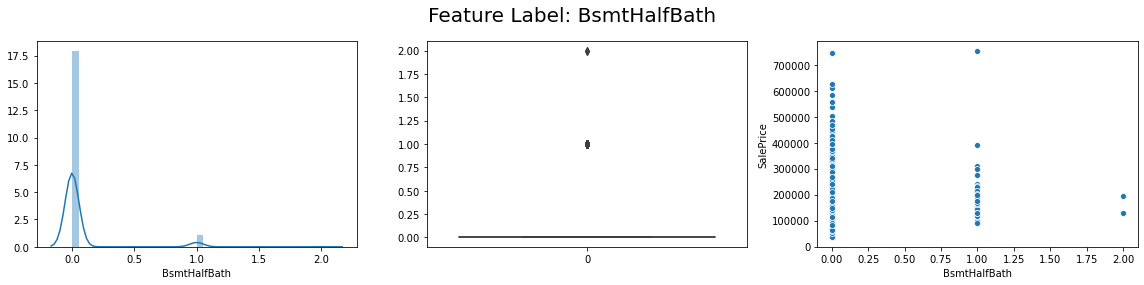

Skew: 4.088583470927076,
Kurtosis: 16.266840766681618,

Outlier Count: 82

count    1451.000000
mean        0.057891
std         0.239449
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: BsmtHalfBath, dtype: float64


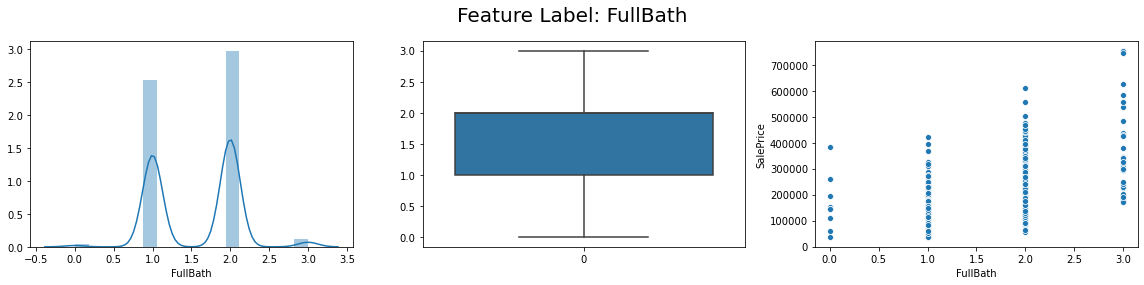

Skew: 0.037756439286998095,
Kurtosis: -0.8680872124225907,

Outlier Count: 0

count    1451.000000
mean        1.562371
std         0.550301
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: FullBath, dtype: float64


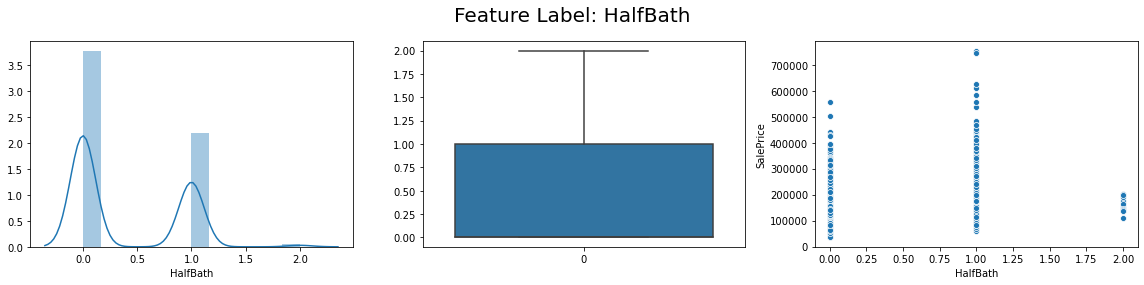

Skew: 0.6851276113330176,
Kurtosis: -1.060728352860473,

Outlier Count: 0

count    1451.000000
mean        0.381116
std         0.502574
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: HalfBath, dtype: float64


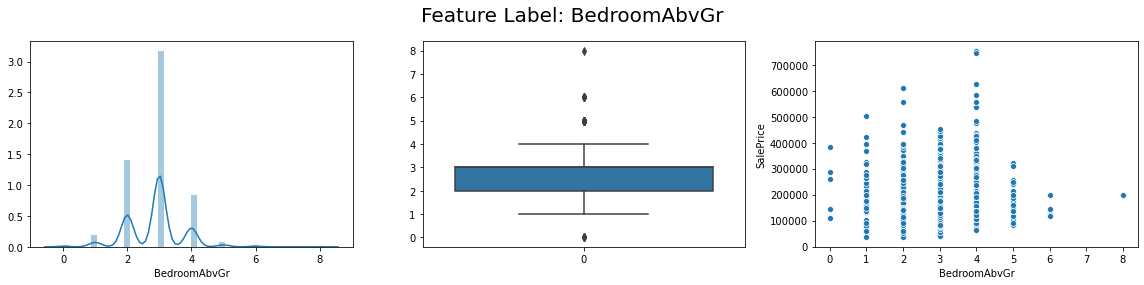

Skew: 0.21784687671324457,
Kurtosis: 2.254820678690478,

Outlier Count: 29

count    1451.000000
mean        2.866988
std         0.815086
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         8.000000
Name: BedroomAbvGr, dtype: float64


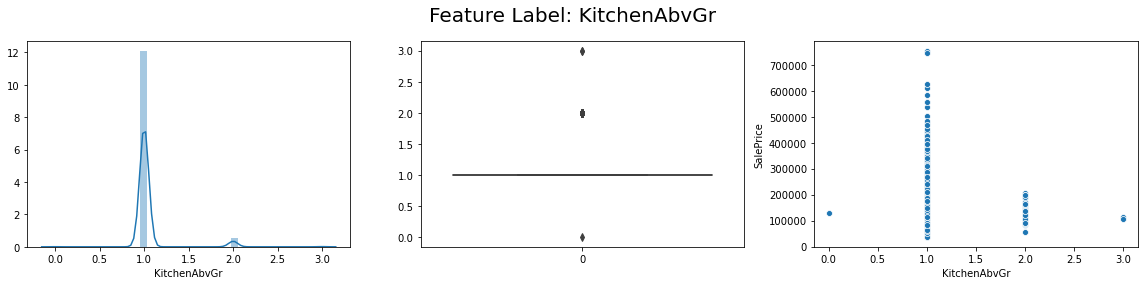

Skew: 4.512817302504021,
Kurtosis: 21.819197404098166,

Outlier Count: 66

count    1451.000000
mean        1.046175
std         0.219571
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: KitchenAbvGr, dtype: float64


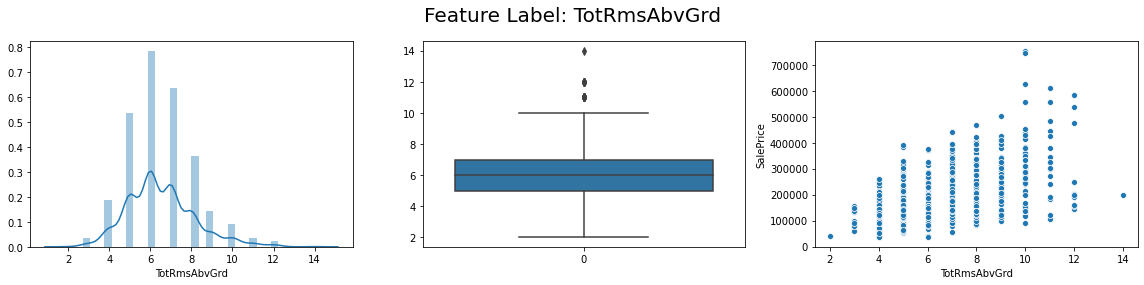

Skew: 0.6808626334316268,
Kurtosis: 0.8863725363554393,

Outlier Count: 30

count    1451.000000
mean        6.516885
std         1.626576
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        14.000000
Name: TotRmsAbvGrd, dtype: float64


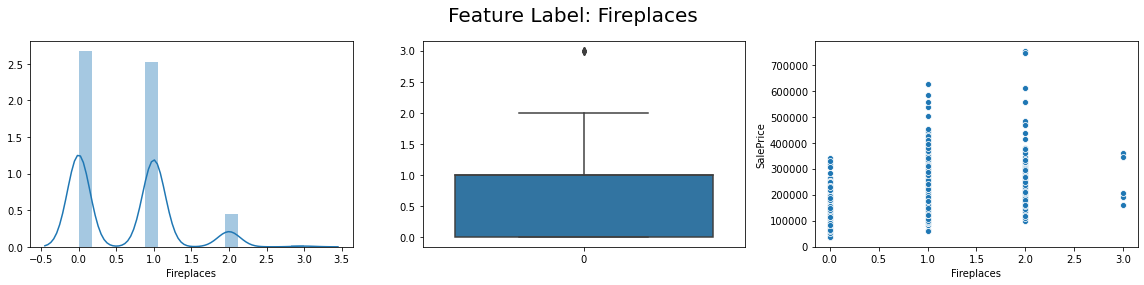

Skew: 0.6477441194695555,
Kurtosis: -0.21007698265350427,

Outlier Count: 5

count    1451.000000
mean        0.612681
std         0.643443
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: Fireplaces, dtype: float64


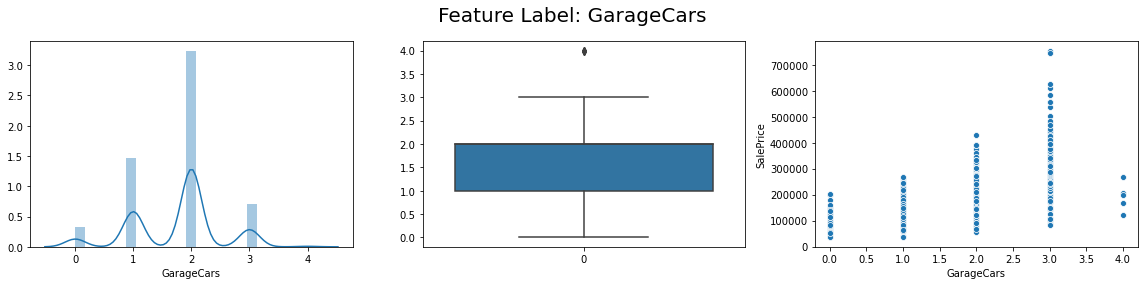

Skew: -0.3374185582736461,
Kurtosis: 0.20757493259321524,

Outlier Count: 5

count    1451.000000
mean        1.764990
std         0.748728
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: GarageCars, dtype: float64


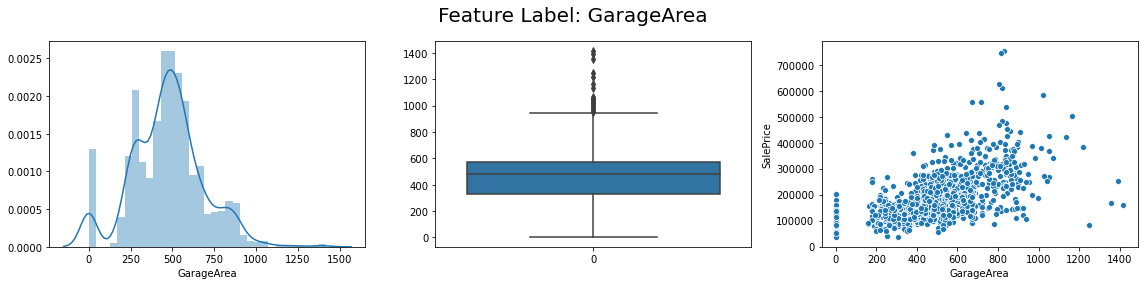

Skew: 0.18258498282307278,
Kurtosis: 0.9092646116469947,

Outlier Count: 20

count    1451.000000
mean      472.525155
std       214.171752
min         0.000000
25%       327.500000
50%       478.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64


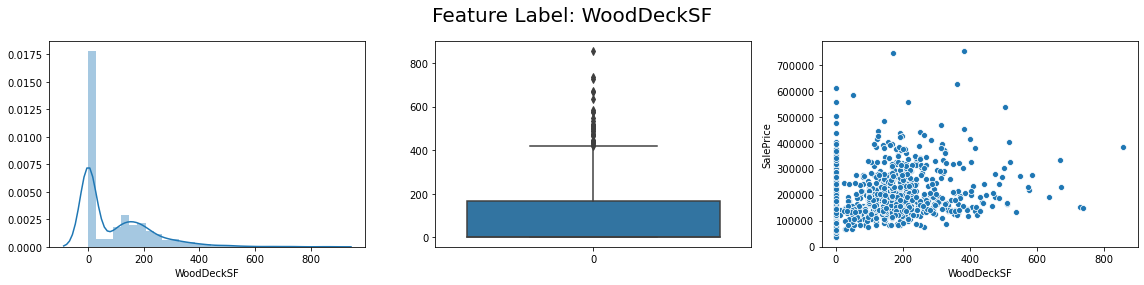

Skew: 1.5418716169970634,
Kurtosis: 2.9972592856988975,

Outlier Count: 32

count    1451.000000
mean       94.412819
std       125.436852
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max       857.000000
Name: WoodDeckSF, dtype: float64


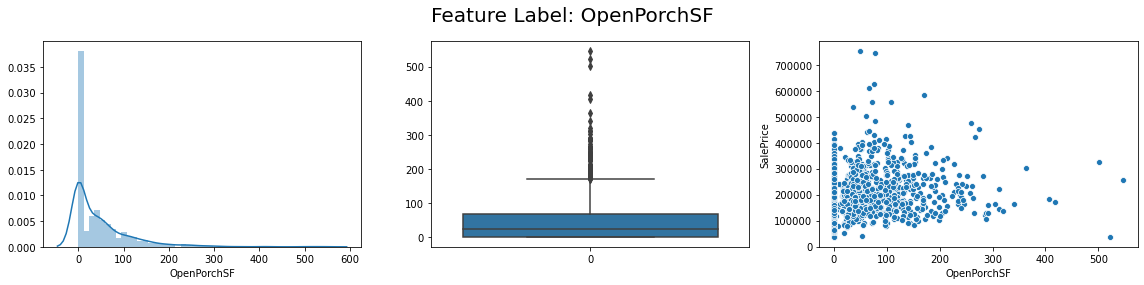

Skew: 2.38490828478105,
Kurtosis: 8.664993444939986,

Outlier Count: 75

count    1451.000000
mean       46.422467
std        66.060150
min         0.000000
25%         0.000000
50%        24.000000
75%        68.000000
max       547.000000
Name: OpenPorchSF, dtype: float64


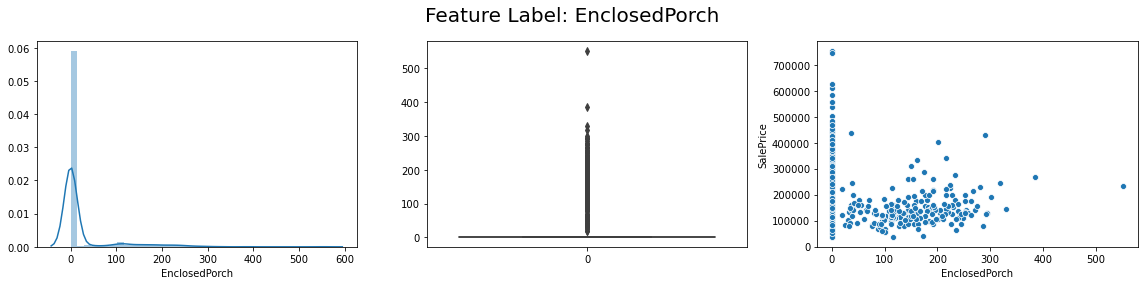

Skew: 3.0940010943007756,
Kurtosis: 10.474484840844404,

Outlier Count: 207

count    1451.000000
mean       21.952447
std        61.108223
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       552.000000
Name: EnclosedPorch, dtype: float64


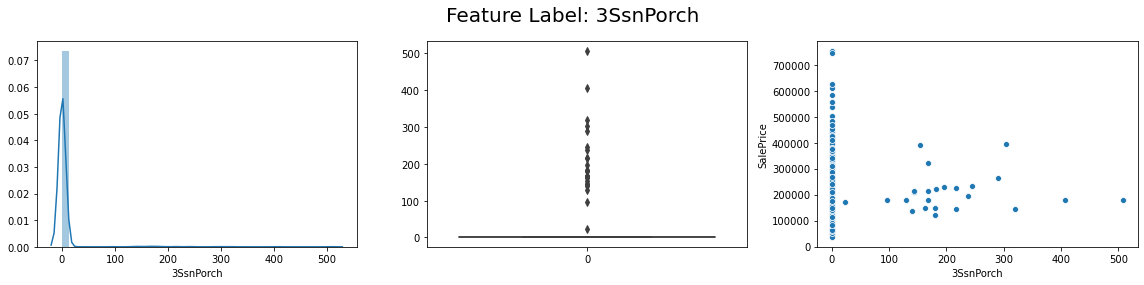

Skew: 10.271741500340108,
Kurtosis: 122.87569154925335,

Outlier Count: 24

count    1451.000000
mean        3.430737
std        29.406940
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       508.000000
Name: 3SsnPorch, dtype: float64


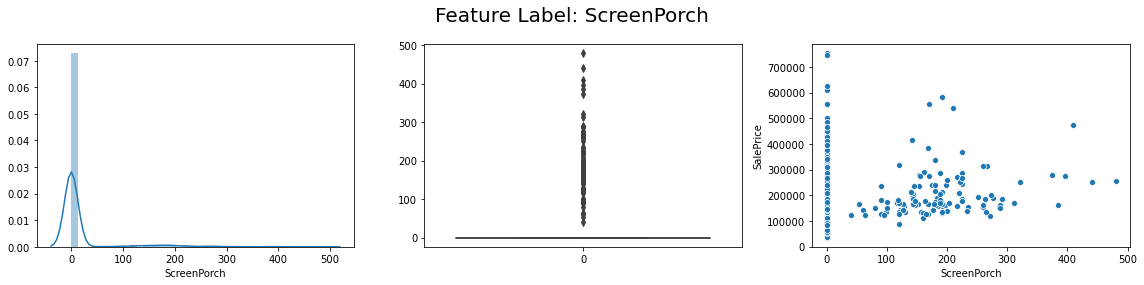

Skew: 4.107410708562218,
Kurtosis: 18.299030438469984,

Outlier Count: 116

count    1451.000000
mean       15.154376
std        55.917522
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       480.000000
Name: ScreenPorch, dtype: float64


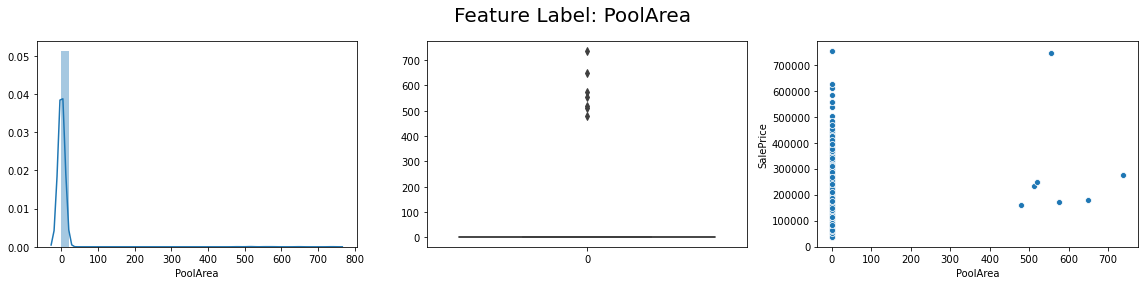

Skew: 14.78206884801823,
Kurtosis: 221.86638768108665,

Outlier Count: 7

count    1451.000000
mean        2.776017
std        40.301212
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       738.000000
Name: PoolArea, dtype: float64


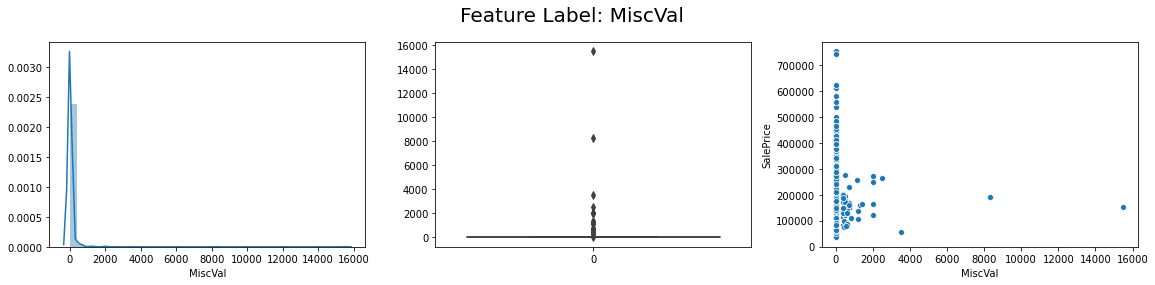

Skew: 24.40151268294567,
Kurtosis: 696.6920940462784,

Outlier Count: 52

count     1451.000000
mean        43.758787
std        497.648467
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64


In [75]:
for _ in cont_features:
    scribe_stats(_)

## Observations of continuous variables ##
- [x] The **Id** and **SalePrice** feature columns need to be dropped.
- [x] There are features that has a continuous data type that is actually categorical in nature. I will change this for the following features.
 - *__'YrSold', 'MoSold', 'MSSubClass', 'OverallCond'__*.
- [x] There are features with ordinal values.  I will create a dictionary with their name and order values for later encoding.
  - *__'OverallQual', 'OverallCond', 'MoSold', 'YrSold'__*.
- [ ] There are quite a few outliers.  Since the data isn't gaussian in nature, I will use the IQR method with a factor value of k=3 to identify extreme or "far outs".
- [x] There are features that have a really high skew.  I atempt a box-cox transform on all of the continuous features to see if we can get a more gaussian distribution.

In [34]:
def column_clean(df):
    
    if ('Id' in df.columns):
        df.drop(columns='Id', axis=1, inplace=True)
        
    if ('SalePrice' in df.columns):
        y_train['SalePrice'] = df.loc[:, 'SalePrice']
        df.drop(columns='SalePrice', axis=1, inplace=True)
    
#     cat_features.extend(one_hot_features)
#     cat_features.extend(category_features)
 
#     final_cont = list(set(cont_features) - set(ordinal_features) - set(one_hot_features))
#     final_cat = list(set(cat_features) - set(ordinal_features))
    
    return df, y_train

In [35]:
X_train_data, y_train = column_clean(X_train_data)

In [36]:
one_hot_features = ['YrSold', 'MoSold', 'MSSubClass', 'OverallQual', \
                    'OverallCond', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']  

for c in one_hot_features:
    X_train_data[c] = X_train_data[c].astype('object')

In [37]:
cont_features, _ = get_feature_list()

In [145]:
a,b = outlier_finder('LotFrontage', 5)

0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0    

Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name:

Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name:

Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name:

Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name:

Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name:

Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name:

Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name:

Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name:

Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name:

Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name:

Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name:

Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name:

Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name:

Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name:

Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name:

Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name:

Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1451, dtype: float64 : 264.0
0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name:

In [147]:
a.value_counts()

934     1
1298    1
dtype: int64

In [130]:
X_train_data[b == False]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
489,180,RM,21.0,1526,Pave,dna,Reg,Lvl,AllPub,Inside,...,0,0,dna,dna,dna,0,5,2009,WD,Normal
614,180,RM,21.0,1491,Pave,dna,Reg,Lvl,AllPub,Inside,...,0,0,dna,dna,dna,0,5,2010,WD,Normal
956,160,RM,24.0,1300,Pave,dna,Reg,Lvl,AllPub,Inside,...,0,0,dna,GdPrv,dna,0,5,2009,WD,Normal
1038,160,RM,21.0,1533,Pave,dna,Reg,Lvl,AllPub,Inside,...,0,0,dna,dna,dna,0,5,2009,WD,Normal
1039,180,RM,21.0,1477,Pave,dna,Reg,Lvl,AllPub,Inside,...,0,0,dna,dna,dna,0,4,2009,WD,Normal
1449,180,RM,21.0,1533,Pave,dna,Reg,Lvl,AllPub,Inside,...,0,0,dna,dna,dna,0,8,2006,WD,Abnorml


In [112]:
out_index = (X_train_data['LotArea'] > \
                           X_train_data['LotArea'].quantile(.99))

In [113]:
out_index.value_counts()

False    1436
True       15
Name: LotArea, dtype: int64

In [101]:
X_train_data.LotArea.quantile(.90)

14375.0

In [102]:
X_train_data.LotArea.describe()

count      1451.000000
mean      10507.808408
std        9992.987081
min        1300.000000
25%        7537.500000
50%        9477.000000
75%       11600.000000
max      215245.000000
Name: LotArea, dtype: float64

In [53]:
for x in cont_features:
    out_count, x_outliers = outlier_finder(x,k=3)
    print(f'{x}: {out_count}')
#     outliers = (X_train_data[(X_train_data[i] > q90)]).any(1)
#     print(i, q90, len(outliers))

LotFrontage: 2
LotArea: 33
MasVnrArea: 25
BsmtFinSF1: 1
BsmtFinSF2: 167
BsmtUnfSF: 0
TotalBsmtSF: 5
1stFlrSF: 3
2ndFlrSF: 0
LowQualFinSF: 26
GrLivArea: 4
BsmtFullBath: 0
BsmtHalfBath: 82
FullBath: 0
HalfBath: 0
BedroomAbvGr: 1
KitchenAbvGr: 66
TotRmsAbvGrd: 1
Fireplaces: 0
GarageCars: 0
GarageArea: 3
WoodDeckSF: 3
OpenPorchSF: 18
EnclosedPorch: 207
3SsnPorch: 24
ScreenPorch: 116
PoolArea: 7
MiscVal: 52


In [58]:
X_train_data.loc[:,x_outliers]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
skew_values = X_train_data.loc[:,cont_features].apply(lambda x: x.skew()) \
.sort_values(ascending=False)
skew_values

In [ ]:
high_skew = X_train_data.loc[:,cont_features].skew() > .5

In [ ]:
from scipy.special import boxcox1p

for s in high_skew.index:
    X_train_data[s] = boxcox1p(X_train_data[s], stats.boxcox_normmax(X_train_data[s]+1))

In [ ]:
for o in cont_features:
    print(f'{o}: {outlier_finder(o)}')

In [ ]:
outliers

In [ ]:
sns.distplot(X_train_data.LotFrontage)
print(X_train_data.LotFrontage.skew())

In [ ]:
for o in cont_features:
    print(f'{o}: {outlier_finder(o)}')

## Catigorical Features <a name='catigorical'></a>
[Table of Contents](#table)

---

In [ ]:
cont_f, cat_f = column_clean(X_train_data)

In [ ]:
 ordinal_dict = {'OverallQual':[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
                 'OverallCond':[1, 2, 3, 4, 5, 6, 7, 8, 9],
                 'MoSold':[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
                 'YrSold':[2006, 2007, 2008, 2009, 2010],
                 'BsmtQual':['dna', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'BsmtCond':['dna', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'BsmtFinType1':['dna','Unf','LwQ','Rec','BLQ', 'ALQ', 'GLQ'],
                 'BsmtFinType2':['dna','Unf','LwQ','Rec','BLQ', 'ALQ', 'GLQ'],
                 'HeatingQC':['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'KitchenQual':['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'Functional':['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
                 'FireplaceQu':['dna', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'GarageQual':['dna', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'GarageCond':['dna', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'PoolQC':['dna','Fa', 'Gd','Ex'],
                 'Fence':['dna', 'MnWw', 'GdWo','MnPrv', 'GdPrv']}


In [ ]:
ordinal_list = [value for key,value in ordinal_dict.items()]

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor, BayesianRidge, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score

### Pipeline <a name='Pipeline'></a>
[Table of Contents](#table)

In [ ]:
continuous_transform = Pipeline([
    ('scaler', StandardScaler()),
])

In [ ]:
categorical_transform = Pipeline([
    ('one_hot', OneHotEncoder(handle_unknown='ignore')),
])

In [ ]:
ordinal_transform = Pipeline([
    ('ordinal', OrdinalEncoder()),
])

In [ ]:
preprocessor = ColumnTransformer([
    ('cont', StandardScaler(), cont_f),
    ('ordinal', OrdinalEncoder(categories=ordinal_list),ordinal_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_f),
])

In [ ]:
linear_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Linear', LinearRegression()),
])

In [ ]:
ridge_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Ridge', Ridge(random_state=24)),
])

In [ ]:
huber_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Huber', HuberRegressor(max_iter=2000)),
])

In [ ]:
lasso_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Lasso', Lasso(random_state=24, fit_intercept=True)),
])

In [ ]:
elastic_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('ElasticNet', ElasticNet(random_state=24))
])

In [ ]:
svm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('SVM', LinearSVR(epsilon=1.5))
])

In [ ]:
tree_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Tree', RandomForestRegressor(n_estimators=500, max_leaf_nodes=16,n_jobs=-1))
])

In [ ]:
pipe_list = [linear_pipe, ridge_pipe, huber_pipe, lasso_pipe, elastic_pipe, svm_pipe, tree_pipe]

In [ ]:
def display_scores():
    
    rmse_dict = dict(Model=[],Mean=[],STD=[],Scores=[])

    for pipe in pipe_list:
        scores = cross_val_score(pipe, X_train_data, log1p, scoring='neg_mean_squared_error', cv=5)
        rmse_pipe = np.sqrt(-scores)
        
        rmse_dict['Model'].append(pipe.steps[1][0])
        rmse_dict['Mean'].append(rmse_pipe.mean())
        rmse_dict['STD'].append(rmse_pipe.std())
        rmse_dict['Scores'].append(rmse_pipe)
        
    return pd.DataFrame(rmse_dict)

In [ ]:
display_scores()

In [ ]:
vote_pipe = VotingRegressor([
    ('linear', linear_pipe), ('tree', tree_pipe), ('svc', svm_pipe)],
    n_jobs=-1)

In [ ]:
vote = Pipeline([
    ('preprocessor', preprocessor),
    ('vote',vote_pipe)
])

In [ ]:
scores = cross_val_score(vote_pipe, X_train_data, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_pipe = np.sqrt(-scores)
print(f'{pipe.steps[1][0]}')
print(f'{rmse_pipe.mean()}')
print(f'{rmse_pipe.std()}')
print(f'{rmse_pipe}')

In [ ]:
ada_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('AdaBoost', DecisionTreeRegressor(random_state=24)),
])

In [ ]:
scores = cross_val_score(ada_pipe, X_train_data, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_pipe = np.sqrt(-scores)
print(f'{rmse_pipe.mean()}')
print(f'{rmse_pipe.std()}')
print(f'{rmse_pipe}')